In [1]:
import numpy as np
import os
import random
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpus = tf.config.experimental.list_physical_devices('GPU')
import pathlib
import cv2
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
working_path            = pathlib.Path().resolve()
path_object             = pathlib.Path(working_path)
parent_path             = path_object.parent
raw_data_path           = os.path.join(parent_path, "data/raw/training/")

In [3]:
# Reading the data oldschool like
data = []
groundtruth = []
Files = ['groundtruth', 'images']

for files in Files:
    cpath = os.path.join(raw_data_path, files)
    for img in os.listdir(cpath):
        image_array = cv2.imread(os.path.join(cpath, img), cv2.IMREAD_COLOR)
        if files=="images":
            data.append(image_array)
        else:
            groundtruth.append(image_array)
images = np.array(data)
masks =  np.array(groundtruth)

In [4]:
def some_vals(images,masks):
    print("Shape Images: "+str(images.shape))
    print("Shape Masks: "+str(masks.shape))
    print("Max Images: "+str(np.max(images)))
    print("Max Masks: "+str(np.max(masks)))
    print("Min Images: "+str(np.min(images)))
    print("Min Masks: "+str(np.min(masks)))

In [5]:
some_vals(images,masks)

Shape Images: (144, 400, 400, 3)
Shape Masks: (144, 400, 400, 3)
Max Images: 255
Max Masks: 255
Min Images: 0
Min Masks: 0


In [6]:
img_size = 128
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_size, img_size), method="nearest")
    input_mask = tf.image.resize(input_mask, (img_size, img_size), method="nearest")
    return input_image, input_mask
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask  = tf.image.flip_left_right(input_mask)
#         input_image = tf.image.rot90(input_image)
#         input_mask  = tf.image.rot90(input_mask)
        
    return input_image, input_mask
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.uint8)

    return input_image, input_mask
def load_image_train(input_image, input_mask):
    input_image, input_mask = resize(input_image, input_mask)
#     input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask
def load_image_test(input_image, input_mask):
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [7]:
from enum import Enum
from tqdm import tqdm
# mask color codes
class MaskColorMap(Enum):
    Other = (0, 0, 0)
    Road = (255, 255, 255)

def integer_encoded_mask(masks):

    # initialise list for integer encoded masks
    integer_encoded_labels = []

    # iterate over each mask
    for mask in tqdm(masks):

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create new mask of zeros
        encoded_image = np.zeros((_img_height, _img_width, 1))

        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j

        # append encoded image
        integer_encoded_labels.append(encoded_image)

    # return one-hot encoded labels
    return np.array(integer_encoded_labels).astype(int)

In [8]:
masks_ohe = integer_encoded_mask(masks)

100%|███████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 103.67it/s]


In [9]:
X_train,X_test,Y_train,Y_test = train_test_split(images,masks_ohe,test_size=0.1,random_state=42)
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, Y_train)))
test_ds = (tf.data.Dataset.from_tensor_slices((X_test, Y_test)))

In [10]:
train_dataset = train_ds.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_ds.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(10).batch(1).repeat()
test_batches = test_dataset.skip(10).take(5).batch(1)

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

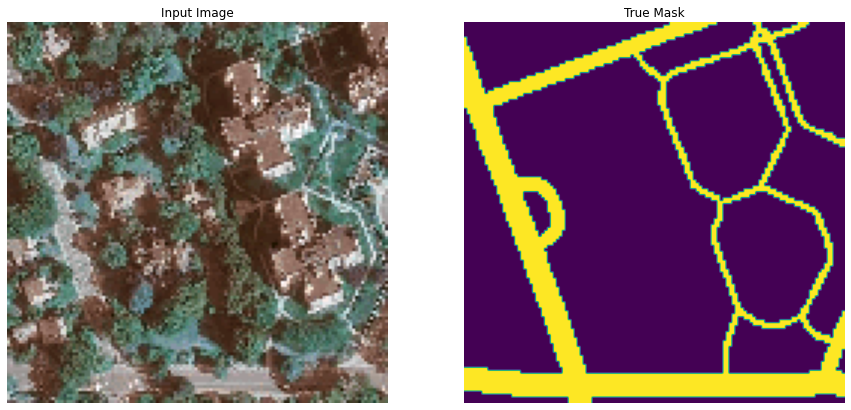

In [13]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [14]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [15]:
def build_unet_model(img_size):

    # inputs
    inputs = layers.Input(shape=(img_size,img_size,3))
    
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [16]:
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
mode_autosave = ModelCheckpoint("./weights/2.0.h5",monitor='val_iou_score', 
                                   mode = 'max', save_best_only=True, verbose=1, period =3)

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, 
                               verbose=1,
                               monitor='val_iou_score', 
                               mode = 'max',
                               restore_best_weights=True
                              ) 

# tensorboard for monitoring logs
tensorboard = TensorBoard(log_dir='./logs/2.0', histogram_freq=0,
                          write_graph=True, write_images=False)

callbacks = [mode_autosave, lr_reducer, tensorboard, early_stopping]
tf.keras.backend.clear_session()
unet_model = build_unet_model(img_size)
# unet_model.summary()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
                   loss=["sparse_categorical_crossentropy",bce_jaccard_loss], 
                   metrics=[iou_score,"accuracy"])

Segmentation Models: using `keras` framework.


In [17]:
NUM_EPOCHS = 100
STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 10

model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches,
                              callbacks = callbacks)

Epoch 1/100
100/100 [==============================] - 47s 390ms/step - loss: 0.4455 - iou_score: 0.1431 - accuracy: 0.8183 - val_loss: 0.3876 - val_iou_score: 0.1614 - val_accuracy: 0.8128 - lr: 5.0000e-04
Epoch 2/100
100/100 [==============================] - 37s 372ms/step - loss: 0.4046 - iou_score: 0.1487 - accuracy: 0.8272 - val_loss: 0.3643 - val_iou_score: 0.1906 - val_accuracy: 0.8322 - lr: 5.0000e-04
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.3529 - iou_score: 0.1765 - accuracy: 0.8527
Epoch 3: val_iou_score improved from -inf to 0.22046, saving model to ./weights\2.0.h5
100/100 [==============================] - 38s 383ms/step - loss: 0.3529 - iou_score: 0.1765 - accuracy: 0.8527 - val_loss: 0.2952 - val_iou_score: 0.2205 - val_accuracy: 0.8785 - lr: 5.0000e-04
Epoch 4/100
100/100 [==============================] - 37s 374ms/step - loss: 0.3074 - iou_score: 0.2029 - accuracy: 0.8735 - val_loss: 0.2596 - val_iou_score: 0.2693 - val_accuracy: 0.89

Epoch 31/100
100/100 [==============================] - 33s 327ms/step - loss: 0.0485 - iou_score: 0.4306 - accuracy: 0.9795 - val_loss: 0.4838 - val_iou_score: 0.3404 - val_accuracy: 0.9141 - lr: 5.0000e-05
Epoch 32/100
100/100 [==============================] - 33s 326ms/step - loss: 0.0481 - iou_score: 0.4312 - accuracy: 0.9797 - val_loss: 0.4804 - val_iou_score: 0.3386 - val_accuracy: 0.9129 - lr: 5.0000e-05
Epoch 33/100
100/100 [==============================] - ETA: 0s - loss: 0.0474 - iou_score: 0.4311 - accuracy: 0.9800
Epoch 33: val_iou_score improved from 0.33868 to 0.34000, saving model to ./weights\2.0.h5
100/100 [==============================] - 33s 333ms/step - loss: 0.0474 - iou_score: 0.4311 - accuracy: 0.9800 - val_loss: 0.5042 - val_iou_score: 0.3400 - val_accuracy: 0.9137 - lr: 5.0000e-05
Epoch 34/100
100/100 [==============================] - 33s 326ms/step - loss: 0.0470 - iou_score: 0.4278 - accuracy: 0.9801 - val_loss: 0.4939 - val_iou_score: 0.3385 - val_accura

In [18]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()

In [19]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 222ms/step


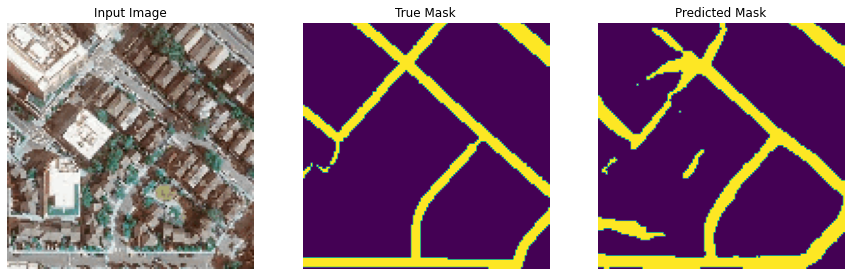

1/1 [==============================] - 0s 22ms/step


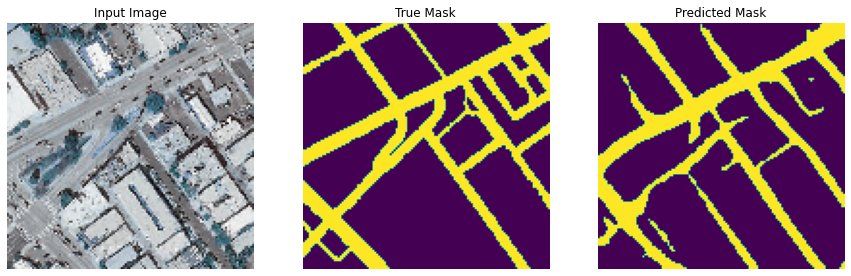

1/1 [==============================] - 0s 22ms/step


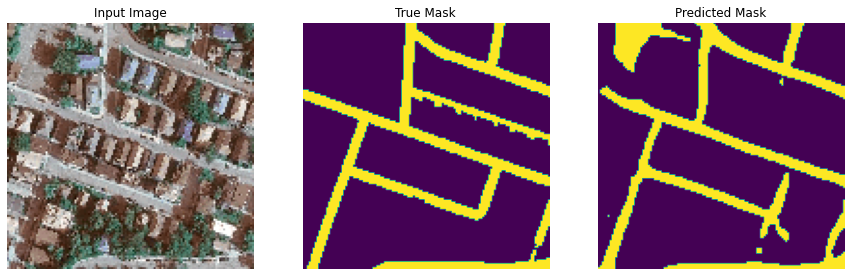

In [22]:
show_predictions(validation_batches, 3)